In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Conv2D, Dropout, UpSampling2D, Concatenate, Input, MaxPooling2D
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
import pandas as pd
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from tensorflow import keras
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

Segmentation Models: using `tf.keras` framework.


In [2]:
!pip install -U -q segmentation-models --user

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [5]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".XX"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

## **Data Reading**

In [7]:
images_path = "/kaggle/input/vessels-segmentation/retina"
masks_path = "/kaggle/input/vessels-segmentation/mask"

In [8]:
images_names = sorted(os.listdir(images_path))
images_names[:10]

['1.png',
 '10.png',
 '100.png',
 '1000.png',
 '1001.png',
 '1002.png',
 '1003.png',
 '1004.png',
 '1005.png',
 '1006.png']

In [9]:
masks_names = sorted(os.listdir(masks_path))
masks_names[:10]

['1.png',
 '10.png',
 '100.png',
 '1000.png',
 '1001.png',
 '1002.png',
 '1003.png',
 '1004.png',
 '1005.png',
 '1006.png']

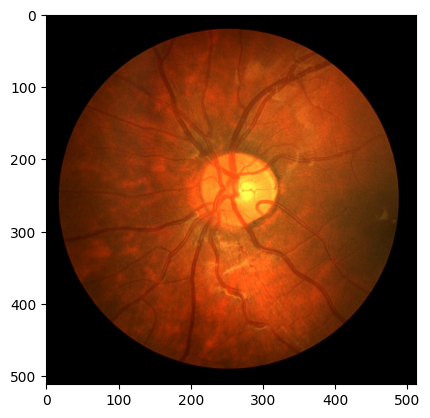

In [10]:
img_path = os.path.join(images_path, images_names[0])
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [11]:
img.shape

(512, 512, 3)

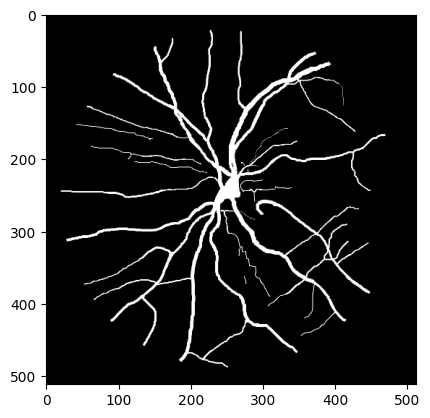

In [12]:
mask_path = os.path.join(masks_path, masks_names[0])
mask = cv2.imread(mask_path)
plt.imshow(mask)

In [13]:
mask.shape

(512, 512, 3)

## **Data Preparation**

In [14]:
images = sorted([ os.path.join(images_path, image_name) for image_name in images_names])
masks = sorted([ os.path.join(masks_path, mask_name) for mask_name in masks_names])

In [15]:
images[:5]

['/kaggle/input/vessels-segmentation/retina/1.png',
 '/kaggle/input/vessels-segmentation/retina/10.png',
 '/kaggle/input/vessels-segmentation/retina/100.png',
 '/kaggle/input/vessels-segmentation/retina/1000.png',
 '/kaggle/input/vessels-segmentation/retina/1001.png']

In [16]:
masks[:5]

['/kaggle/input/vessels-segmentation/mask/1.png',
 '/kaggle/input/vessels-segmentation/mask/10.png',
 '/kaggle/input/vessels-segmentation/mask/100.png',
 '/kaggle/input/vessels-segmentation/mask/1000.png',
 '/kaggle/input/vessels-segmentation/mask/1001.png']

In [17]:
# images = np.zeros((len(images_names), 512, 512, 3))
# masks = np.zeros((len(masks_names), 512, 512, 1))
# count = 0

# for img_name, mask_name in zip(images_names, masks_names):

#     img_path = os.path.join(images_path, img_name)
#     img = cv2.imread(img_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     images[count] = img/255.0
    
#     mask_path = os.path.join(masks_path, mask_name)
#     mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#     mask = cv2.resize(mask, (512, 512))
#     masks[count] = np.expand_dims(mask, axis=-1) / 255.0   

#     count += 1

## **Data Preprocessing**

- **Contrast Limited Adaptive Histogram Equalization (CLAHE)**

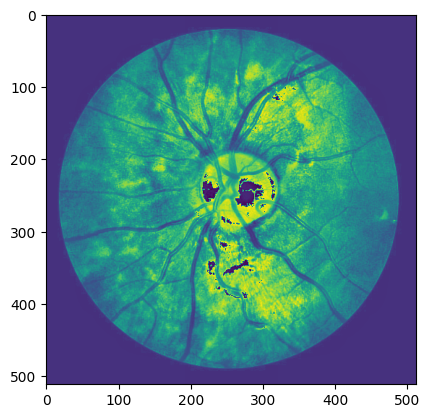

In [33]:
clahe = cv2.createCLAHE(clipLimit=5)
img_bw = cv2.cvtColor(cv2.imread(images[0]), cv2.COLOR_BGR2GRAY)
clahe_img = clahe.apply(img_bw) + 30
plt.imshow(clahe_img)

## **Data Splitting**

In [19]:
x_train, x_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=0)

In [20]:
len(x_train), len(x_test)

(839, 210)

## **Data Generator**

In [21]:
IMAGE_SIZE = 512
BATCH_SIZE = 16

def read_files(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.divide(image, 255)
        image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.cast(image, tf.int32)
    else:
        image = tf.image.decode_png(image, channels=4)
        image = image[:,:,:3]
        image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 255.
    return image

def load_data(image_list, mask_list):
    image = read_files(image_list)
    mask  = read_files(mask_list, mask=True)
    return image, mask

def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
    return dataset

In [22]:
x_train[:5]

['/kaggle/input/vessels-segmentation/retina/413.png',
 '/kaggle/input/vessels-segmentation/retina/427.png',
 '/kaggle/input/vessels-segmentation/retina/49.png',
 '/kaggle/input/vessels-segmentation/retina/220.png',
 '/kaggle/input/vessels-segmentation/retina/807.png']

In [23]:
train_gen = data_generator(x_train, y_train)
train_gen

<_BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.int32, name=None))>

In [24]:
len(x_test)

210

In [25]:
val_gen = data_generator(x_test[:200], y_test[:200])
val_gen

<_BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.int32, name=None))>

In [26]:
test_gen = data_generator(x_test[200:], y_test[200:])
test_gen

<_BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.int32, name=None))>

## **Data Generator**

In [27]:
# images_gen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# masks_gen = ImageDataGenerator(
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

In [28]:
# images_gen = ImageDataGenerator(rescale=1./255)
# masks_gen = ImageDataGenerator(rescale=1./255)

In [88]:
# train_gen = images_gen.flow(
#     x_train, 
#     y_train,
#     batch_size=32
# )

# test_gen = masks_gen.flow(
#     x_test, 
#     y_test,
#     batch_size=32
# )

In [76]:
# train_gen[0]

In [89]:
# batch_size = 32

## **Models**
- https://paperswithcode.com/sota/retinal-vessel-segmentation-on-drive

## **Model 1: U-Net**
- https://github.com/Callidior/keras-applications.git

### **Model Architecture**

In [92]:
!pip install -U -q segmentation-models --user

In [91]:
keras.backend.clear_session()
model = sm.Unet('efficientnetb0', classes=1, activation='sigmoid')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ input_layer[0][0] │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 32)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │        512 │ block1a_se_excit… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      1,536 │ block1a_project_… │
│ (Conv2D)            │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b

 Total params: 10,115,501 (38.59 MB)

 Trainable params: 10,071,501 (38.42 MB)

 Non-trainable params: 44,000 (171.88 KB)

In [144]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### **Model Training**

In [151]:
model.fit(train_gen, epochs=30)

Epoch 1/30


2024-06-23 22:19:06.499804: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[256,1952,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,1952,32,32]{3,2,1,0}, f32[16,256,32,32]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-23 22:19:08.303010: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.80329026s
Trying algorithm eng0{} for conv (f32[256,1952,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,1952,32,32]{3,2,1,0}, f32[16,256,32,32]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-23 22:19:10.211692: E extern

52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.8205 - loss: 0.4761

2024-06-23 22:21:17.147799: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[256,1952,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,1952,32,32]{3,2,1,0}, f32[7,256,32,32]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-23 22:21:17.384320: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.236705084s
Trying algorithm eng0{} for conv (f32[256,1952,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,1952,32,32]{3,2,1,0}, f32[7,256,32,32]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-23 22:21:18.805950: E external/

53/53 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.8240 - loss: 0.4690
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 434ms/step - accuracy: 0.9734 - loss: 0.1014
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 434ms/step - accuracy: 0.9780 - loss: 0.0729
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 435ms/step - accuracy: 0.9803 - loss: 0.0617
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 435ms/step - accuracy: 0.9816 - loss: 0.0558
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 435ms/step - accuracy: 0.9825 - loss: 0.0518
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 435ms/step - accuracy: 0.9832 - loss: 0.0491
Epoch 8/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 435ms/step - accuracy: 0.9836 - loss: 0.0473
Epoch 9/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 434ms/step - accuracy: 0.9838 - loss: 0.0461
Epoch 10/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 436ms/step - accuracy: 0.9837 - loss: 0.0466
Epoch 11/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 434ms/step - accuracy: 0.9843 - loss: 0.0442
Epoch 12/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 434ms/step 

In [181]:
model.evaluate(val_gen)

13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9818 - loss: 0.0517 


[0.048117659986019135, 0.982893168926239]

### **Model Testing**

In [184]:
predictions = model.predict(test_gen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step


In [187]:
predictions[:2]

array([[[[1.16154142e-02],
         [1.66667206e-03],
         [1.60229509e-03],
         ...,
         [1.32356433e-03],
         [1.30034366e-03],
         [8.62041209e-03]],

        [[3.11423559e-03],
         [1.29398148e-04],
         [1.58768162e-04],
         ...,
         [1.25614621e-04],
         [9.52551854e-05],
         [7.43692275e-04]],

        [[2.38080067e-03],
         [9.37997320e-05],
         [1.27043153e-04],
         ...,
         [1.32213332e-04],
         [7.97201355e-05],
         [6.28461712e-04]],

        ...,

        [[1.81787217e-03],
         [5.39240064e-05],
         [6.84338956e-05],
         ...,
         [2.20114496e-04],
         [1.66437429e-04],
         [1.25590956e-03]],

        [[3.49858426e-03],
         [9.01758467e-05],
         [8.49834032e-05],
         ...,
         [1.88595412e-04],
         [1.98670066e-04],
         [1.29085069e-03]],

        [[3.67381275e-02],
         [1.95841724e-03],
         [1.37678755e-03],
         ...,
 

In [189]:
for batch in test_gen:
    test_images, test_masks = batch

In [190]:
len(test_images)

10

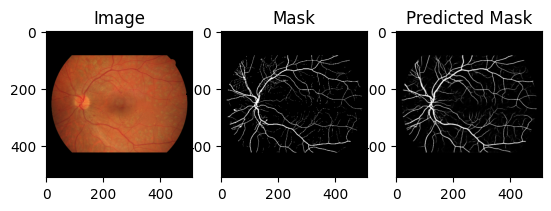

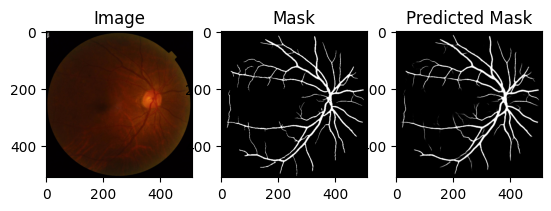

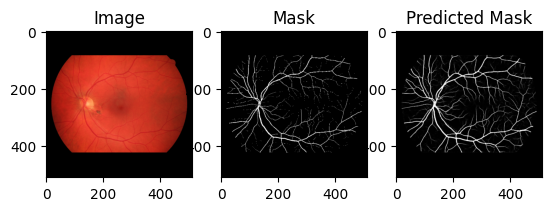

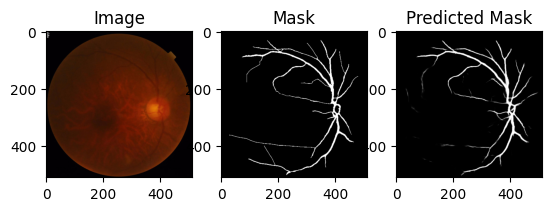

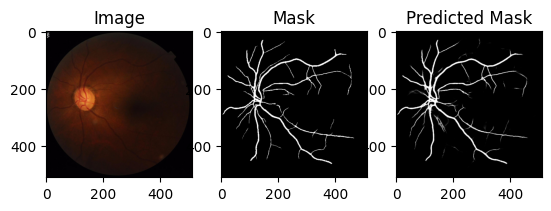

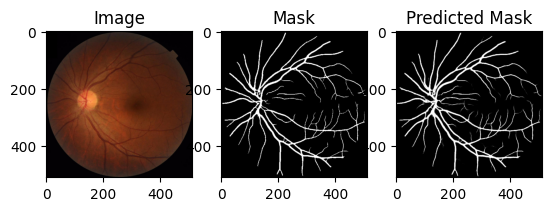

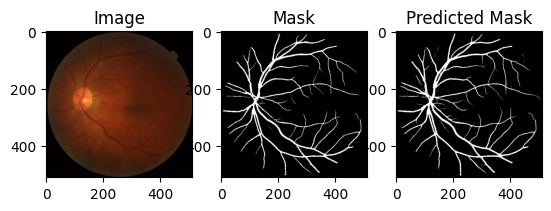

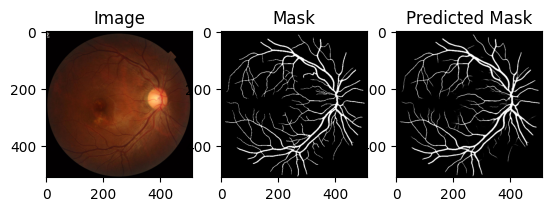

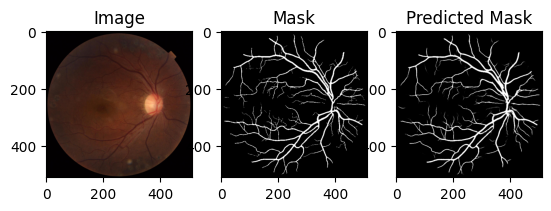

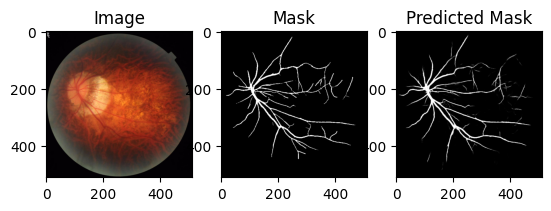

In [202]:
for i in range(10):
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i])
    plt.title('Image')

    plt.subplot(1, 3, 2)
    plt.imshow(test_masks[i], cmap='gray')
    plt.title("Mask")
    
    plt.subplot(1, 3, 3)
    plt.imshow(predictions[i], cmap='gray')
    plt.title('Predicted Mask')

    plt.show()

In [204]:
model.save('model.h5')

In [237]:
saved_model = load_model('model.h5')

In [248]:
predict_mask = model.predict(image_gen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [238]:
images[0]

'/kaggle/input/vessels-segmentation/retina/1.png'

In [240]:
image_gen

<_BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.int32, name=None))>

In [241]:
for batch in image_gen:
    image, mask = batch

In [242]:
image

<tf.Tensor: shape=(1, 512, 512, 3), dtype=float32, numpy=
array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]], dty

In [ ]:
def generator(image):
    
    def read_files(image_path, mask=False):
        image = tf.io.read_file(image_path)
        if mask:
            image = tf.image.decode_png(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.divide(image, 255)
            image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
            image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
            image = tf.cast(image, tf.int32)
        else:
            image = tf.image.decode_png(image, channels=4)
            image = image[:,:,:3]
            image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
            image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
            image = image / 255.
        return image

    def load_data(image_list, mask_list):
        image = read_files(image_list)
        mask  = read_files(mask_list, mask=True)
        return image, mask

    def data_generator(image_list, mask_list):
        dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
        dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.batch(1, drop_remainder=False)
        return dataset
    
    return data_generator([image], [image])
    
image_gen = generator(images[0])   

In [249]:
predict_mask

array([[[[1.1486151e-02],
         [1.6258692e-03],
         [1.5578705e-03],
         ...,
         [1.2949397e-03],
         [1.2772779e-03],
         [8.5288538e-03]],

        [[3.1041026e-03],
         [1.2739764e-04],
         [1.5768207e-04],
         ...,
         [1.2238038e-04],
         [9.3018294e-05],
         [7.3457358e-04]],

        [[2.4089473e-03],
         [9.3413844e-05],
         [1.2505207e-04],
         ...,
         [1.3117144e-04],
         [7.9506193e-05],
         [6.2942645e-04]],

        ...,

        [[1.7895323e-03],
         [5.1454575e-05],
         [6.5480679e-05],
         ...,
         [2.1992256e-04],
         [1.5782722e-04],
         [1.1617109e-03]],

        [[3.4228829e-03],
         [8.6298947e-05],
         [8.1694423e-05],
         ...,
         [1.8404113e-04],
         [1.8495378e-04],
         [1.2157381e-03]],

        [[3.6414761e-02],
         [1.8852549e-03],
         [1.3050304e-03],
         ...,
         [2.0009333e-03],
        

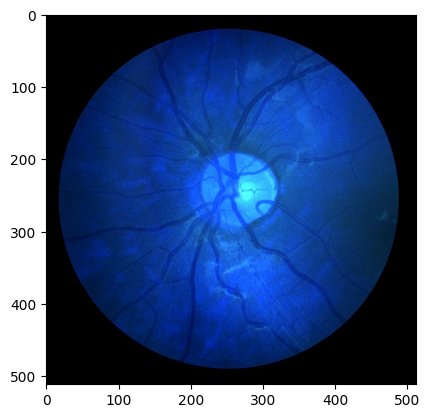

In [253]:
plt.imshow(cv2.imread(images[0]))

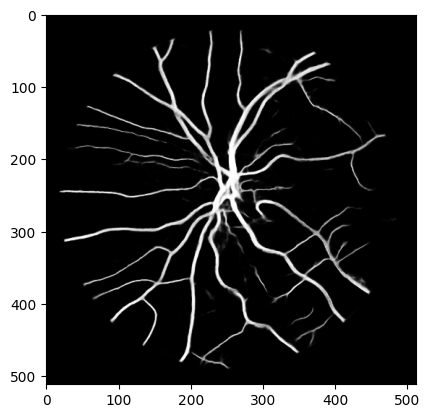

In [252]:
plt.imshow(np.squeeze(predict_mask), cmap='gray')

In [254]:
predict_mask = saved_model.predict(image_gen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


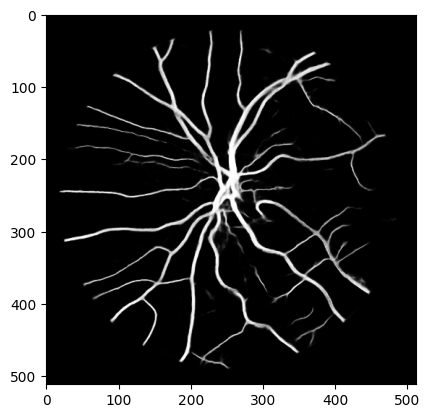

In [255]:
plt.imshow(np.squeeze(predict_mask), cmap='gray')

In [260]:
un_seen = "/kaggle/input/lets-test/retina_new.png"

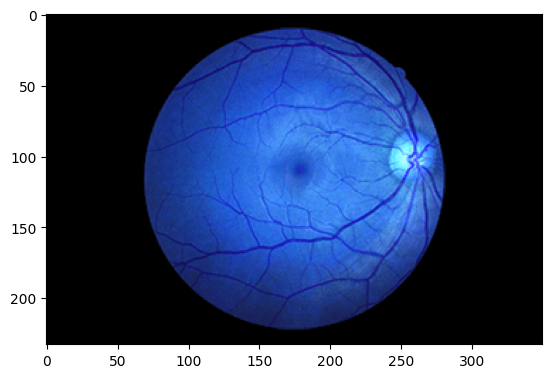

In [261]:
plt.imshow(cv2.imread(un_seen))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


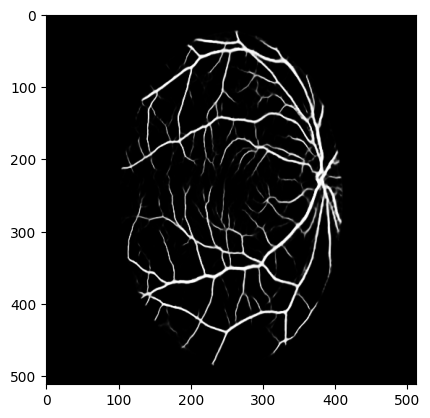

In [262]:
predict_mask = saved_model.predict(generator(un_seen))
plt.imshow(np.squeeze(predict_mask), cmap='gray')

In [263]:
predict_mask.shape

(1, 512, 512, 1)

## **Model 2: Simple U-Net**

In [267]:
inputs = Input((512, 512, 3))
c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
p1 = MaxPooling2D((2, 2))(c1)
u1 = UpSampling2D((2, 2))(p1)
c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
outputs = Conv2D(1, (1, 1), activation='sigmoid')(c2)
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [270]:
model.fit(train_gen, epochs=30)

Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9378 - loss: 0.2062
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.9378 - loss: 0.2058
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9378 - loss: 0.2055
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9378 - loss: 0.2050
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9378 - loss: 0.2045
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.9378 - loss: 0.2037
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9378 - loss: 0.2023
Epoch 8/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.9378 - loss: 0.2003
Epoch 9/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9378 - loss: 0.1972
Epoch 10/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9378 - loss: 0.1930
Epoch 11/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9381 - loss: 0.1873
Epoch 12/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step

## **Model 3: Simple LinkNet**

In [29]:
model1 = sm.Linknet('efficientnetb0', classes=1, activation='sigmoid')
model1.summary()

16804768/16804768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ input_layer[0][0] │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 32)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │        512 │ block1a_se_excit… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      1,536 │ block1a_project_… │
│ (Conv2D)            │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b

 Total params: 6,096,333 (23.26 MB)

 Trainable params: 6,049,549 (23.08 MB)

 Non-trainable params: 46,784 (182.75 KB)

In [30]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
model1.fit(train_gen, epochs=30)

Epoch 1/30


I0000 00:00:1719207736.504845     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


53/53 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.8763 - loss: 0.3859
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 388ms/step - accuracy: 0.9731 - loss: 0.0960
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 387ms/step - accuracy: 0.9772 - loss: 0.0712
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 387ms/step - accuracy: 0.9790 - loss: 0.0631
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 388ms/step - accuracy: 0.9803 - loss: 0.0578
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 386ms/step - accuracy: 0.9812 - loss: 0.0545
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 387ms/step - accuracy: 0.9817 - loss: 0.0524
Epoch 8/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 386ms/step - accuracy: 0.9824 - loss: 0.0500
Epoch 9/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 390ms/step - accuracy: 0.9825 - loss: 0.0498
Epoch 10/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 386ms/step - accuracy: 0.9825 - loss: 0.0490
Epoch 11/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 387ms/step - accuracy: 0.9832 - loss: 0.0473
Epoch 12/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 387ms/step 

In [32]:
model1.evaluate(val_gen)

13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9842 - loss: 0.0480 


[0.043038152158260345, 0.9854547381401062]

## **U-Net Model Deployment**

- **Our Generator takes (image, mask) as parameters.**
- **In Production, I don't have the mask to pass it with the image, So I pass the image twice to the generator and i won't use the second part(repeated image) and model will predict the original image only.**

- **And also i thought that we can use a black mask, but to not care about the dimensions and reshaping the filter, Using the image twice will be suiable and easy solution**

In [239]:
def generator(image):
    
    def read_files(image_path, mask=False):
        image = tf.io.read_file(image_path)
        if mask:
            image = tf.image.decode_png(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.divide(image, 255)
            image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
            image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
            image = tf.cast(image, tf.int32)
        else:
            image = tf.image.decode_png(image, channels=4)
            image = image[:,:,:3]
            image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
            image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
            image = image / 255.
        return image

    def load_data(image_list, mask_list):
        image = read_files(image_list)
        mask  = read_files(mask_list, mask=True)
        return image, mask

    def data_generator(image_list, mask_list):
        dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
        dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.batch(1, drop_remainder=False)
        return dataset
    
    return data_generator([image], [image])

image = images[0] # path
image_gen = generator(image) 
saved_model = load_model('model.h5')   
predict_mask = saved_model.predict(image_gen)
plt.imshow(np.squeeze(predict_mask), cmap='gray')